# Multi-Step Time Series Forecasting for  household electricity consumption  using LSTM




### Problem Description

The ‘Household Power Consumption‘ dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

    global_active_power: The total active power consumed by the household (kilowatts).
    global_reactive_power: The total reactive power consumed by the household (kilowatts).
    voltage: Average voltage (volts).
    global_intensity: Average current intensity (amps).
    sub_metering_1: Active energy for kitchen (watt-hours of active energy).
    sub_metering_2: Active energy for laundry (watt-hours of active energy).
    sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

The dataset can be downloaded from the UCI Machine Learning repository as a single 20 megabyte .zip file:

Link https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan
from numpy import isnan

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
#Load and Prepare Dataset

# load all data
data = pd.read_csv('household_power_consumption.txt', sep=';',low_memory=False, parse_dates=True)
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
#combine/concat the first two columns into a single date-time column that we can use as an index.
data['datetime']=data['Date'].str.cat(data['Time'],sep=' ')
data.head(2)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00


In [4]:
data.drop(['Date','Time'],inplace=True,axis=1)
data.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00


In [5]:
data.set_index(['datetime'],inplace=True)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [7]:
# mark all missing values
data.replace('?', nan, inplace=True)
# make dataset numeric
data = data.astype('float32')

In [8]:
np.isnan(data).sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
data.values.shape

(2075259, 7)

In [10]:
# fill missing values with a value at the same time one day ago

def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [11]:
# fill missing
fill_missing(data.values)

In [12]:
np.isnan(data).sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtypes: float32(7)
memory usage: 71.2+ MB


In [14]:
data.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
16/12/2006 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0


In [15]:
# save updated dataset
#data.to_csv('updated_household_power_consumption.csv')

## downsample the per-minute observations of power consumption to daily totals

In [16]:
# load the new file
dataset = pd.read_csv('updated_household_power_consumption.csv', parse_dates=True, index_col='datetime',low_memory=False)


In [17]:
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()

In [18]:
# summarize
print(daily_data.shape)
print(daily_data.head())

(1457, 7)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
datetime                                                                      
2006-12-16            5180.8             0.0           546.0          4926.0  
2006-12-17           14398.6          2033.0          4187.0         13341.0  
2006-12-18            9247.2          1063.0          2621.0         14018.0  
2006-12-19            7094.0           839.0          7602.0          6197.0  
2006-12-20            9313.0    

## Patterns in Observations Over Time

In [19]:
len(daily_data.columns)

7

C:\Users\AnuragMishra\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


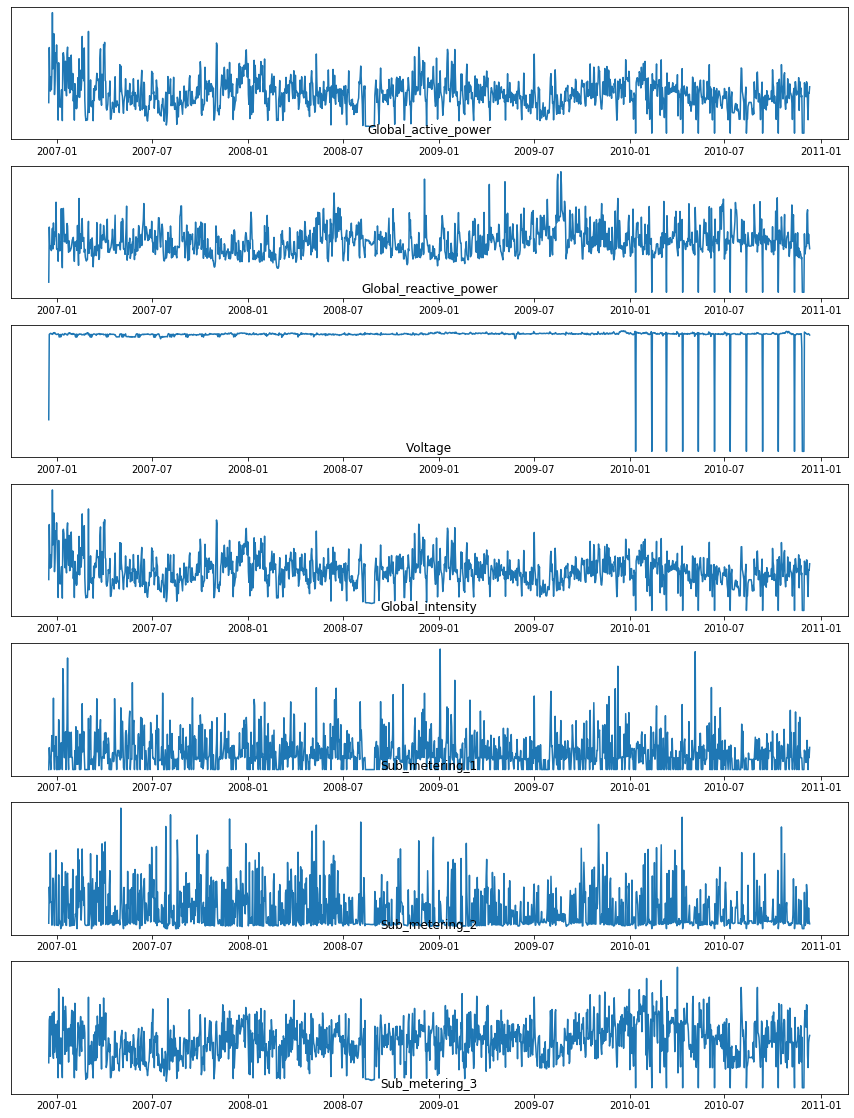

In [20]:
fig, ax= plt.subplots(figsize=(15,20))
 
    
for i in range(len(daily_data.columns)):
    plt.subplot(len(daily_data.columns),1,i+1)
    name=daily_data.columns[i]
    plt.plot(daily_data[name])
    plt.title(name,y=0)
    plt.yticks([])
plt.show()
fig.tight_layout()

### Exploring Global active power

In [21]:
years=['2007','2008','2009','2010']

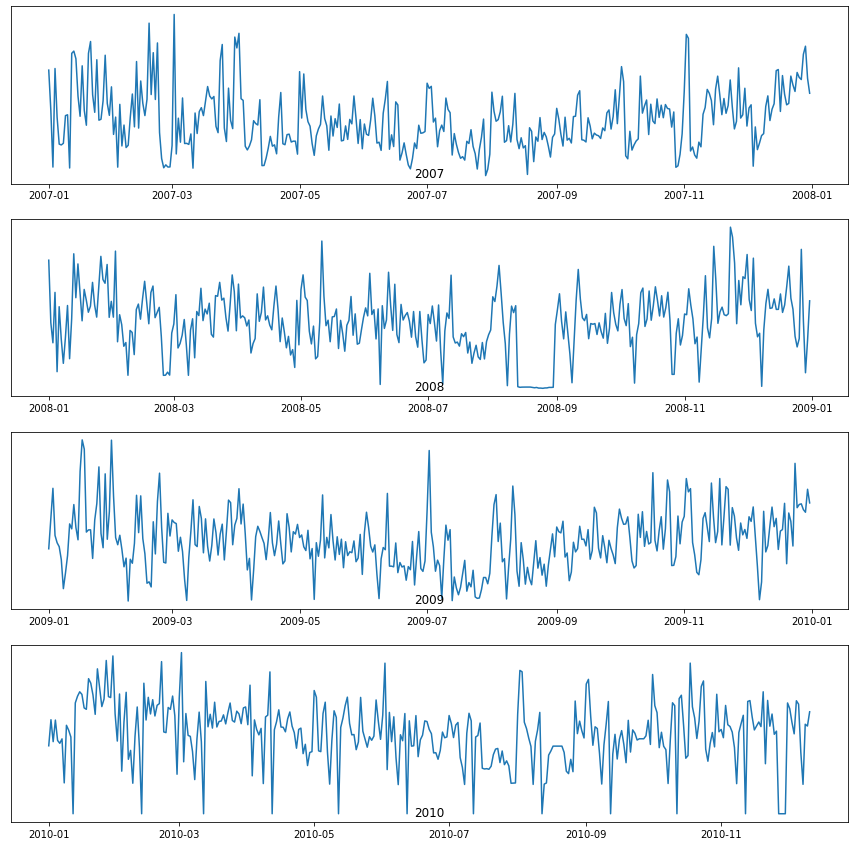

In [22]:
fig, ax= plt.subplots(figsize=(15,15))
 
    
for i in range(len(years)):
    plt.subplot(len(years),1,i+1)
    year=years[i]
    active_power_data=daily_data[str(year)]
    plt.plot(active_power_data['Global_active_power'])
    plt.title(str(year),y=0)
    plt.yticks([])
plt.show()
fig.tight_layout()

### Plot Power consumption for each month of 2007

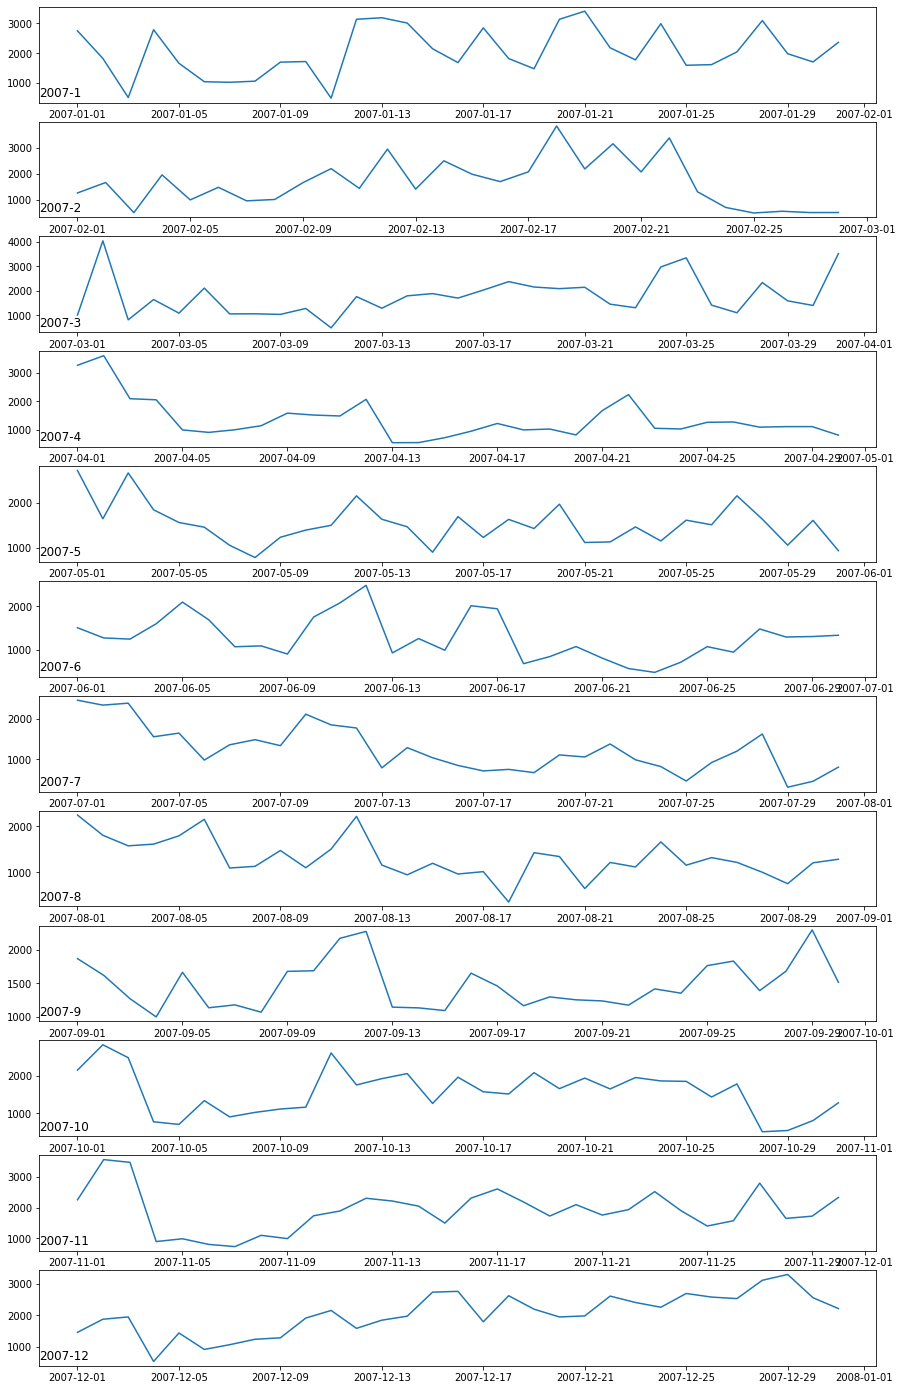

In [23]:
# monthly line plots

months = [x for x in range(1, 13)]
plt.figure(figsize=(15,25))
for i in range(len(months)):
	# prepare subplot
	ax = plt.subplot(len(months), 1, i+1)
	# determine the month to plot
	month = '2007-' + str(months[i])
	# get all observations for the month
	result = daily_data[month]
	# plot the active power for the month
	plt.plot(result['Global_active_power'])
	# add a title to the subplot
	plt.title(month, y=0, loc='left')
plt.show()

## Time Series Data Distributions

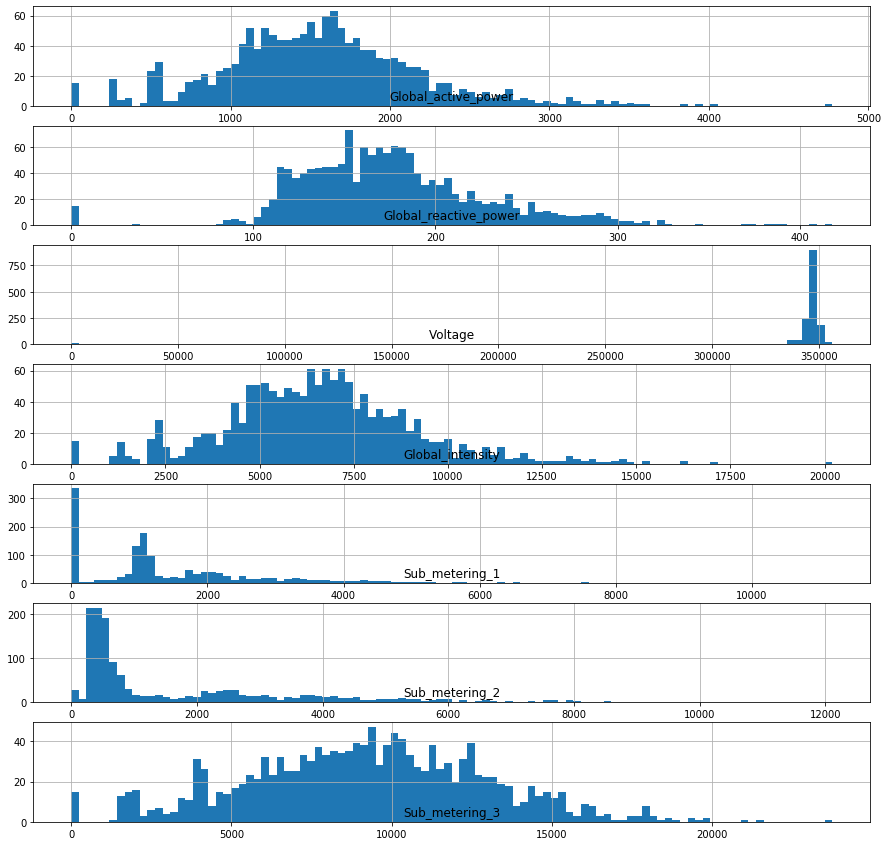

In [24]:
# histogram plot for each variable
plt.figure(figsize=(15,15))
for i in range(len(daily_data.columns)):
	plt.subplot(len(daily_data.columns), 1, i+1)
	name = daily_data.columns[i]
	daily_data[name].hist(bins=100)
	plt.title(name, y=0)
plt.show()

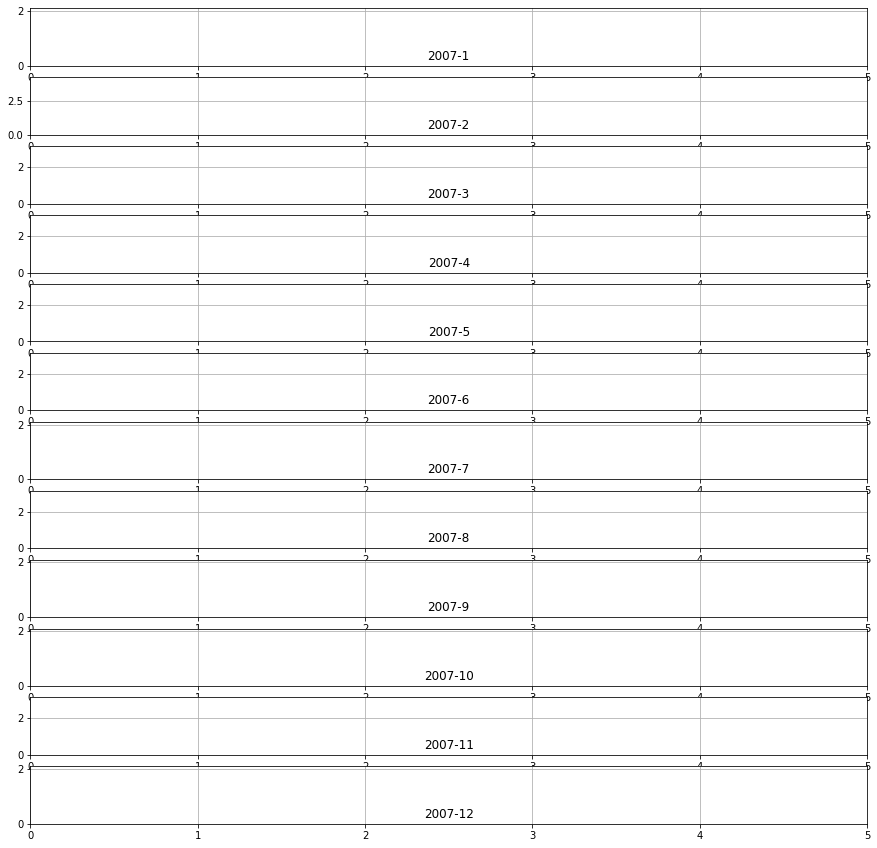

In [25]:
# plot active power for each year
months = [i for i in range(1, 13)]

fig, ax= plt.subplots(figsize=(15,15))

for i in range(len(months)):
    # prepare subplot
    ax=plt.subplot(len(months), 1, i+1)
    # determine the month to plot
    month = '2007-' + str(months[i])
    # get all observations for the month
    result = daily_data[month]
    # plot the active power for the month
    result['Global_active_power'].hist(bins=100)
    # zoom in on the distribution
    ax.set_xlim(0, 5)
    # add a title to the subplot
    plt.title(month, y=0)
plt.show()
fig.tight_layout()

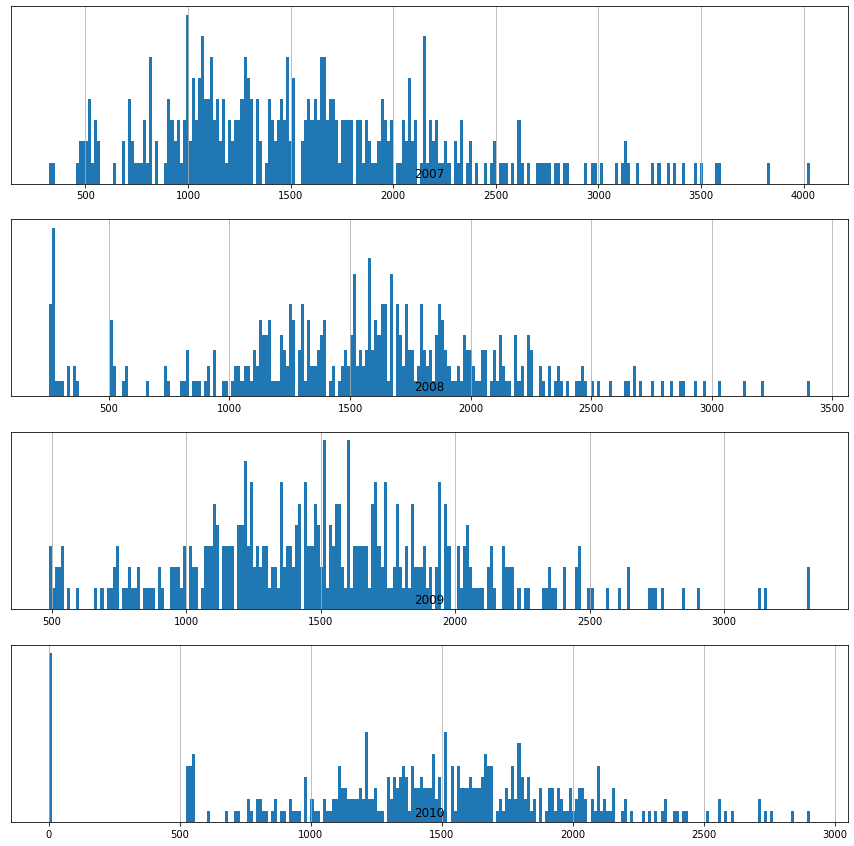

In [26]:
fig, ax= plt.subplots(figsize=(15,15))
 
    
for i in range(len(years)):
    plt.subplot(len(years),1,i+1)
    year=years[i]
    active_power_data=daily_data[str(year)]
    active_power_data['Global_active_power'].hist(bins=250)
    plt.title(str(year),y=0)
    plt.yticks([])
plt.show()
fig.tight_layout()

## LSTM model 

#### split  dataset into train/test sets

In [66]:
data_train=daily_data.loc[:'2009-12-31',:]['Global_active_power']
data_train.head()

datetime
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Freq: D, Name: Global_active_power, dtype: float64

In [67]:
data_test=daily_data.loc['2010']['Global_active_power']
data_test.head()

datetime
2010-01-01    1224.252
2010-01-02    1693.778
2010-01-03    1298.728
2010-01-04    1687.440
2010-01-05    1320.158
Freq: D, Name: Global_active_power, dtype: float64

In [68]:
data_train.shape,data_test.shape

((1112,), (345,))

### training data preperation

In [69]:
data_train.head(14)

datetime
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
2006-12-21    1723.288
2006-12-22    2341.338
2006-12-23    4773.386
2006-12-24    2550.012
2006-12-25    2743.120
2006-12-26    3934.110
2006-12-27    1528.760
2006-12-28    2072.638
2006-12-29    3174.392
Freq: D, Name: Global_active_power, dtype: float64

In [77]:
data_train=np.array(data_train)

In [78]:
len(data_train)-7

1105

In [79]:
x_train=[]
y_train=[]
 

In [80]:
for i in range(7,len(data_train)-7):
    x_train.append(data_train[i-7:i])
    y_train.append(data_train[i:i+7])
                 

In [81]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_train.shape,y_train.shape


((1098, 7), (1098, 7))

In [82]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6
0,4773.386,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392
1,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108
2,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196
3,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004
4,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004,1824.760
...,...,...,...,...,...,...,...
1093,1144.166,2034.966,1888.022,1455.200,2905.894,2127.648,2183.618
1094,2034.966,1888.022,1455.200,2905.894,2127.648,2183.618,2195.452
1095,1888.022,1455.200,2905.894,2127.648,2183.618,2195.452,2094.098
1096,1455.200,2905.894,2127.648,2183.618,2195.452,2094.098,2047.968


In [84]:
x_scalar=MinMaxScaler()
x_train=x_scalar.fit_transform(x_train)

In [85]:
y_scalar=MinMaxScaler()
y_train=y_scalar.fit_transform(y_train)

In [86]:
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6
0,0.211996,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304
1,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000
2,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439
3,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133
4,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133,0.814446


In [87]:
x_train.shape

(1098, 7)

In [88]:
#Reshape the data

x_train=x_train.reshape(1098,7,1)

In [90]:
x_train.shape[1], x_train.shape[2], x_train.shape[1]

(7, 1, 7)

## Build Model

In [96]:
model = Sequential()

# define parameters
verbose, epochs, batch_size = 1, 100, 16
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], x_train.shape[1]

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))


model.compile(loss='mse', optimizer='adam')

In [97]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 707       
Total params: 182,407
Trainable params: 182,407
Non-trainable params: 0
_________________________________________________________________


In [98]:
# fit network
model.fit(x_train,y_train, epochs=100, batch_size=batch_size, verbose=verbose)

Epoch 1/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0467
Epoch 2/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0241
Epoch 3/100
69/69 [==============================] - 1s 13ms/step - loss: 0.0241
Epoch 4/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0239
Epoch 5/100
69/69 [==============================] - 1s 11ms/step - loss: 0.0238
Epoch 6/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0237
Epoch 7/100
69/69 [==============================] - 1s 14ms/step - loss: 0.0235
Epoch 8/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0241
Epoch 9/100
69/69 [==============================] - 1s 13ms/step - loss: 0.0235
Epoch 10/100
69/69 [==============================] - 1s 12ms/step - loss: 0.0235
Epoch 11/100
69/69 [==============================] - 1s 13ms/step - loss: 0.0235
Epoch 12/100
69/69 [==============================] - 1s 15ms/step - loss: 0.0236
Epoch 13/100
69/69 [=====

69/69 [==============================] - 1s 15ms/step - loss: 0.0207


## prepare test dataset

In [111]:
data_test=np.array(data_test)

In [112]:
len(data_test)-7

338

In [113]:
x_test=[]
y_test=[]
 
    
for i in range(7,len(data_test)-7):
    x_test.append(data_test[i-7:i])
    y_test.append(data_test[i:i+7])



In [114]:
x_test=np.array(x_test)
y_test=np.array(y_test)
x_test.shape,y_test.shape

((331, 7), (331, 7))

In [115]:
#pd.DataFrame(y_test)

In [116]:
x_test=x_scalar.transform(x_test)
y_test=y_scalar.transform(y_test)

In [117]:
#Reshape the data

x_test=x_test.reshape(331,7,1)

In [118]:
y_pred=model.predict(x_test)
y_pred

array([[ 0.26605445,  0.32868692,  0.3295123 , ...,  0.35034508,
         0.35637963,  0.33965057],
       [ 0.20675309,  0.32728067,  0.36178565, ...,  0.3546113 ,
         0.36474842,  0.35142404],
       [ 0.29810685,  0.37275216,  0.366561  , ...,  0.37939075,
         0.39093804,  0.35588783],
       ...,
       [ 0.24349397,  0.3749813 ,  0.1759269 , ...,  0.35798505,
         0.18918583, -0.00955488],
       [ 0.27089873,  0.21852887,  0.14713407, ...,  0.20120347,
         0.02289642,  0.03385767],
       [ 0.2809509 ,  0.20964858,  0.19197503, ...,  0.15208274,
         0.09028375,  0.16461834]], dtype=float32)

In [126]:
y_true=y_scalar.inverse_transform(y_test)
y_true

array([[ 555.664, 1593.318, 1504.82 , ...,    0.   , 1995.796, 2116.224],
       [1593.318, 1504.82 , 1383.18 , ..., 1995.796, 2116.224, 2196.76 ],
       [1504.82 , 1383.18 ,    0.   , ..., 2116.224, 2196.76 , 2150.112],
       ...,
       [1892.998, 1645.424, 1439.426, ..., 1973.382, 1109.574,  529.698],
       [1645.424, 1439.426, 2035.418, ..., 1109.574,  529.698, 1612.092],
       [1439.426, 2035.418, 1973.382, ...,  529.698, 1612.092, 1579.692]])

### Evaluate model


In [127]:
from math import sqrt

def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [128]:
evaluate_forecasts(y_true, y_pred)

(1567.4043910292332,
 [1564.084086420374,
  1567.7262024429394,
  1569.041776425717,
  1568.017678971814,
  1566.4592351338795,
  1568.9598726877357,
  1567.5362977381346])

In [129]:
np.std(y_true[0])

710.0253857243853